# Example: postprocess WRF data for offshore wind analysis
Last Updated by Jeffrey Sward on November 2, 2020

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
import wrf.latlonutils as llutils

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF
from optwrf import postwrf, plots

In [2]:
# Define the path to where you WRF data file is stored 
# (note: don't forget to add the "/" at the end of the directory)
wrfout_dir = '/Users/swardy9230/Box Sync/01_Research/01_Renewable_Analysis/Wind Resource Analysis/wrfout/19mp4lw4sw7lsm8pbl99cu/'
wrfout_file = 'wrfout_d01_2011-07-17'

# Process the WRF data
met_data = postwrf.process_wrfout_manual(wrfout_dir, wrfout_file, save_file=False)
met_data

<xarray.Dataset>
Dimensions:         (Time: 40, bottom_top: 35, south_north: 191, west_east: 191)
Coordinates:
    XLONG           (south_north, west_east) float32 -95.43335 ... -64.11832
    XLAT            (south_north, west_east) float32 30.952759 ... 47.507103
  * Time            (Time) datetime64[ns] 2011-07-17 ... 2011-07-18T15:00:00
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    temp_air        (Time, south_north, west_east) float32 34.964813 ... 19.2...
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 0.0 .....
    cos_zenith      (Time, south_north, west_east) float32 0.0 ... 0.84530807
    dni             (Time, south_north, west_east) float32 0.0 0.0 ... 943.1471
    dhi             (Time, south_north, west_east) float32 0.0 0.0 ... 53.327393
    height_agl      (Time, bottom_top, south_north, west_east) float32 10.885...
    wspd            (Time, bottom_top, south_north, west_east) float32 2.2962...
    wdir            (Time, bottom_top, south_north, west_east) float32 169.32...
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 850.5772
    wind_speed100   (Time, south_north, west_east) float32 2.566039 ... 6.393...
    wpd             (Time, south_north, west_east) float32 8448.114 ... 13069...
Attributes:
    TITLE:                            OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE:                      2011-07-17_00:00:00
    SIMULATION_START_DATE:           2011-07-17_00:00:00
    WEST-EAST_GRID_DIMENSION:        192
    SOUTH-NORTH_GRID_DIMENSION:      192
    BOTTOM-TOP_GRID_DIMENSION:       36
    DX:                              12000.0
    DY:                              12000.0
    AERCU_OPT:                       0
    AERCU_FCT:                       1.0
    IDEAL_CASE:                      0
    DIFF_6TH_SLOPEOPT:               0
    AUTO_LEVELS_OPT:                 2
    DIFF_6TH_THRESH:                 0.1
    DZBOT:                           50.0
    DZSTRETCH_S:                     1.3
    DZSTRETCH_U:                     1.1
    SKEBS_ON:                        0
    SPEC_BDY_FINAL_MU:               1
    USE_Q_DIABATIC:                  0
    GRIDTYPE:                        C
    DIFF_OPT:                        1
    KM_OPT:                          4
    DAMP_OPT:                        0
    DAMPCOEF:                        0.2
    KHDIF:                           0.0
    KVDIF:                           0.0
    MP_PHYSICS:                      19
    RA_LW_PHYSICS:                   4
    RA_SW_PHYSICS:                   4
    SF_SFCLAY_PHYSICS:               1
    SF_SURFACE_PHYSICS:              7
    BL_PBL_PHYSICS:                  8
    CU_PHYSICS:                      99
    SF_LAKE_PHYSICS:                 0
    SURFACE_INPUT_SOURCE:            1
    SST_UPDATE:                      0
    GRID_FDDA:                       0
    GFDDA_INTERVAL_M:                0
    GFDDA_END_H:                     0
    GRID_SFDDA:                      0
    SGFDDA_INTERVAL_M:               0
    SGFDDA_END_H:                    0
    HYPSOMETRIC_OPT:                 2
    USE_THETA_M:                     1
    GWD_OPT:                         0
    SF_URBAN_PHYSICS:                0
    SF_SURFACE_MOSAIC:               0
    SF_OCEAN_PHYSICS:                0
    SHCU_PHYSICS:                    0
    MFSHCONV:                        0
    FEEDBACK:                        1
    SMOOTH_OPTION:                   0
    SWRAD_SCAT:                      1.0
    W_DAMPING:                       0
    DT:                              30.0
    RADT:                            15.0
    BLDT:                            0.0
    CUDT:                            0.0
    AER_OPT:                         0
    SWINT_OPT:                       1
    AER_TYPE:                        1
    AER_AOD550_OPT:                  1
    AER_ANGEXP_OPT:                  1
    AER_SSA_OPT:                     1
    AER_ASY_OPT:              

In [3]:
# Interpolate wind speeds to 40m height
wind_speed40 = wrf.interplevel(met_data.wspd, met_data.height_agl, 40)

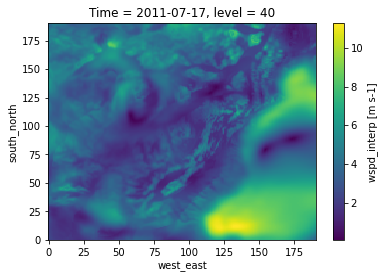

In [4]:
# Select and plot a single time period
wind_speed40.sel(Time='2011-07-17 00').plot()

In [5]:
# Select and plot the time series for a single point
# First, find the x, y indicies for a latitude, longitude pair 
# correspoonding to a specific location (e.g., NYC). 
xy = postwrf.ll_to_xy(met_data, 40.7128, -74.0060)
xy

array([146, 110])

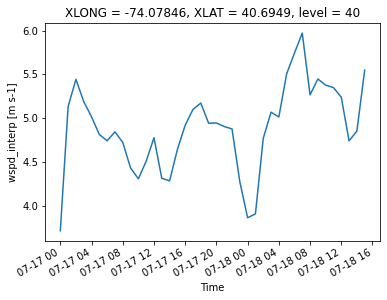

In [6]:
# Now plot the time series from these indicies
# NOTE: Longitude/XLONG (west_east) ~ x; Latitude/XLAT (south_north) ~ y
wind_speed40.isel(west_east=xy[0], south_north=xy[1]).plot()

Closest lat: 40.69490051269531, closest lon: -74.07846069335938


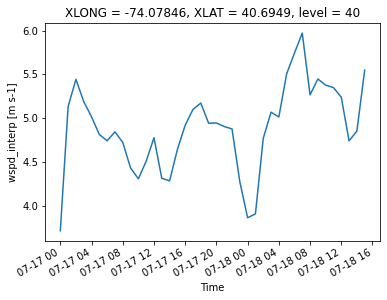

In [7]:
# Here is a different way of doing it that works well for multiple points 
# (i.e., you create a Kdtree_ll_to_xy class and query it )
ns = postwrf.Kdtree_ll_to_xy(met_data,'XLAT','XLONG')
iy,ix = ns.query(40.7128, -74.0060)
print(f'Closest lat: {ns.latvar[iy,ix].values}, closest lon: {ns.lonvar[iy,ix].values}')
wind_speed40.isel(west_east=ix, south_north=iy).plot()